In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"


/Users/alexisletrung/perso/epita/FinalProject_2025_Alexis.LE-TRUNG/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load the data


In [2]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()



,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [3]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()


,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


# Data Analysis

# Check for missing/error values

In [4]:
print(f"=== Check for nan ===")
for column in interactions_train.columns:
    if not interactions_train[interactions_train[column].isna()].empty:
        print(f"Column: {column}")

print(f"=== Check for nan ===")
for column in interactions_test.columns:
    if not interactions_test[interactions_test[column].isna()].empty:
        print(f"Column: {column}")




=== Check for nan ===
=== Check for nan ===
Column: time
Column: date
Column: timestamp


 Commentaire sur les nan ?
 

Nous allons voir si il existe des doublons de pair user/video.


In [8]:
dups_train = interactions_train.groupby(['user_id', 'video_id']).size().reset_index(name='count')

print(f"Ratio of duplicates: {len(dups_train) / len(interactions_train)}")
print(f"Number of duplicates: {len(dups_train)}")

dups_test = interactions_test.groupby(['user_id', 'video_id']).size().reset_index(name='count')

print(f"Ratio of duplicates: {len(dups_test) / len(interactions_test)}")
print(f"Number of duplicates: {len(dups_test)}")

Ratio of duplicates: 0.8220515902967455
Number of duplicates: 10300969
Ratio of duplicates: 1.0
Number of duplicates: 4676570


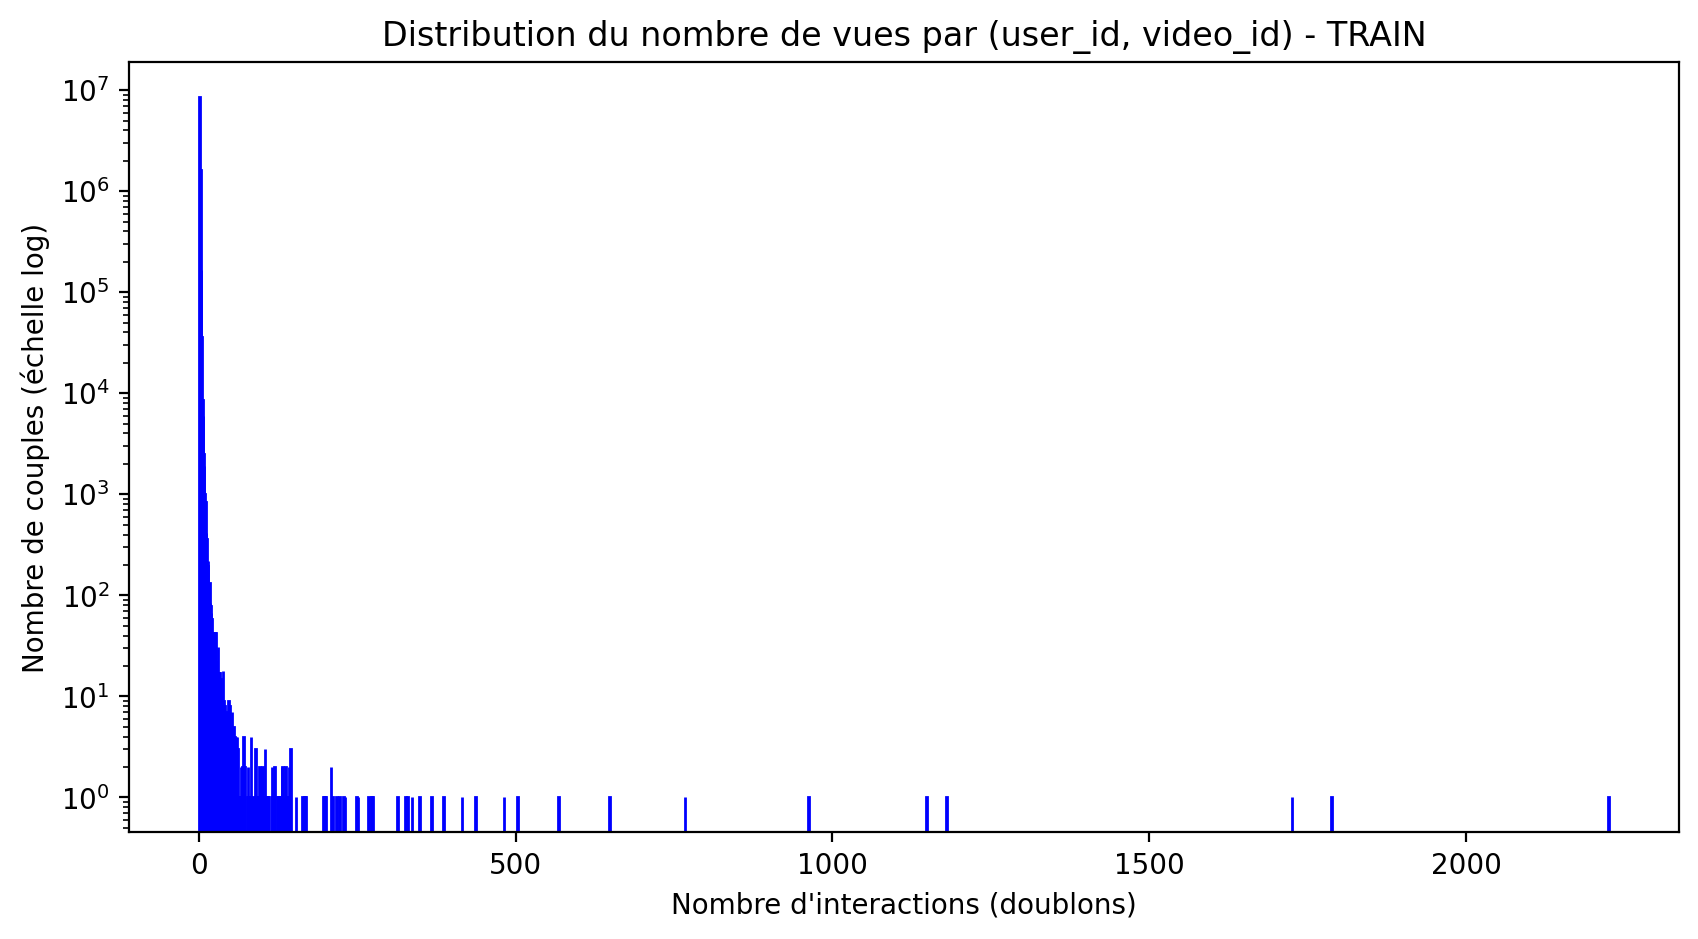

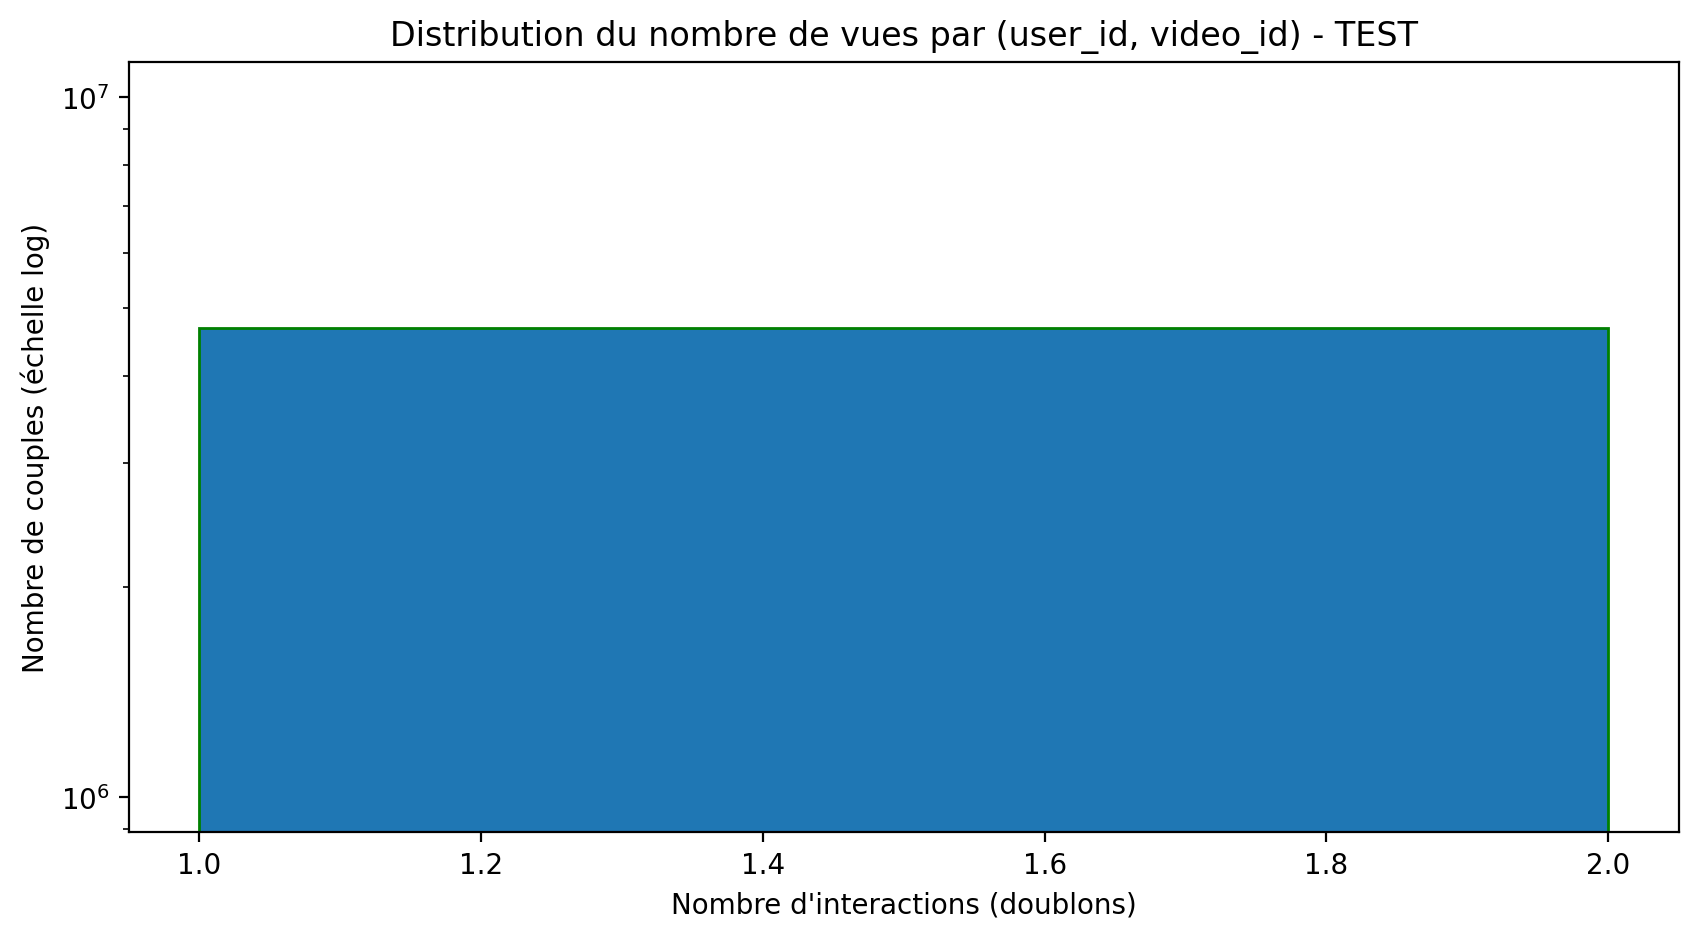

In [11]:
# Visualiser la distribution des doublons dans le train
plt.figure(figsize=(10, 5))
plt.hist(dups_train['count'], bins=range(1, dups_train['count'].max() + 2), edgecolor='blue', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id) - TRAIN")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

# Visualiser la distribution des doublons dans le test
plt.figure(figsize=(10, 5))
plt.hist(dups_test['count'], bins=range(1, dups_test['count'].max() + 2), edgecolor='green', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id) - TEST")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

Cette information est importante, je vais considerer que le watch_ratio sera la somme des doublons.


In [12]:
interactions_train_filtered = interactions_train.groupby(['user_id', 'video_id'], as_index=False)['watch_ratio'].sum()
interactions_test_filtered = interactions_test.groupby(['user_id', 'video_id'], as_index=False)['watch_ratio'].sum()






Max watch_ratio: 6574.981596339603
Min watch_ratio: 0.0


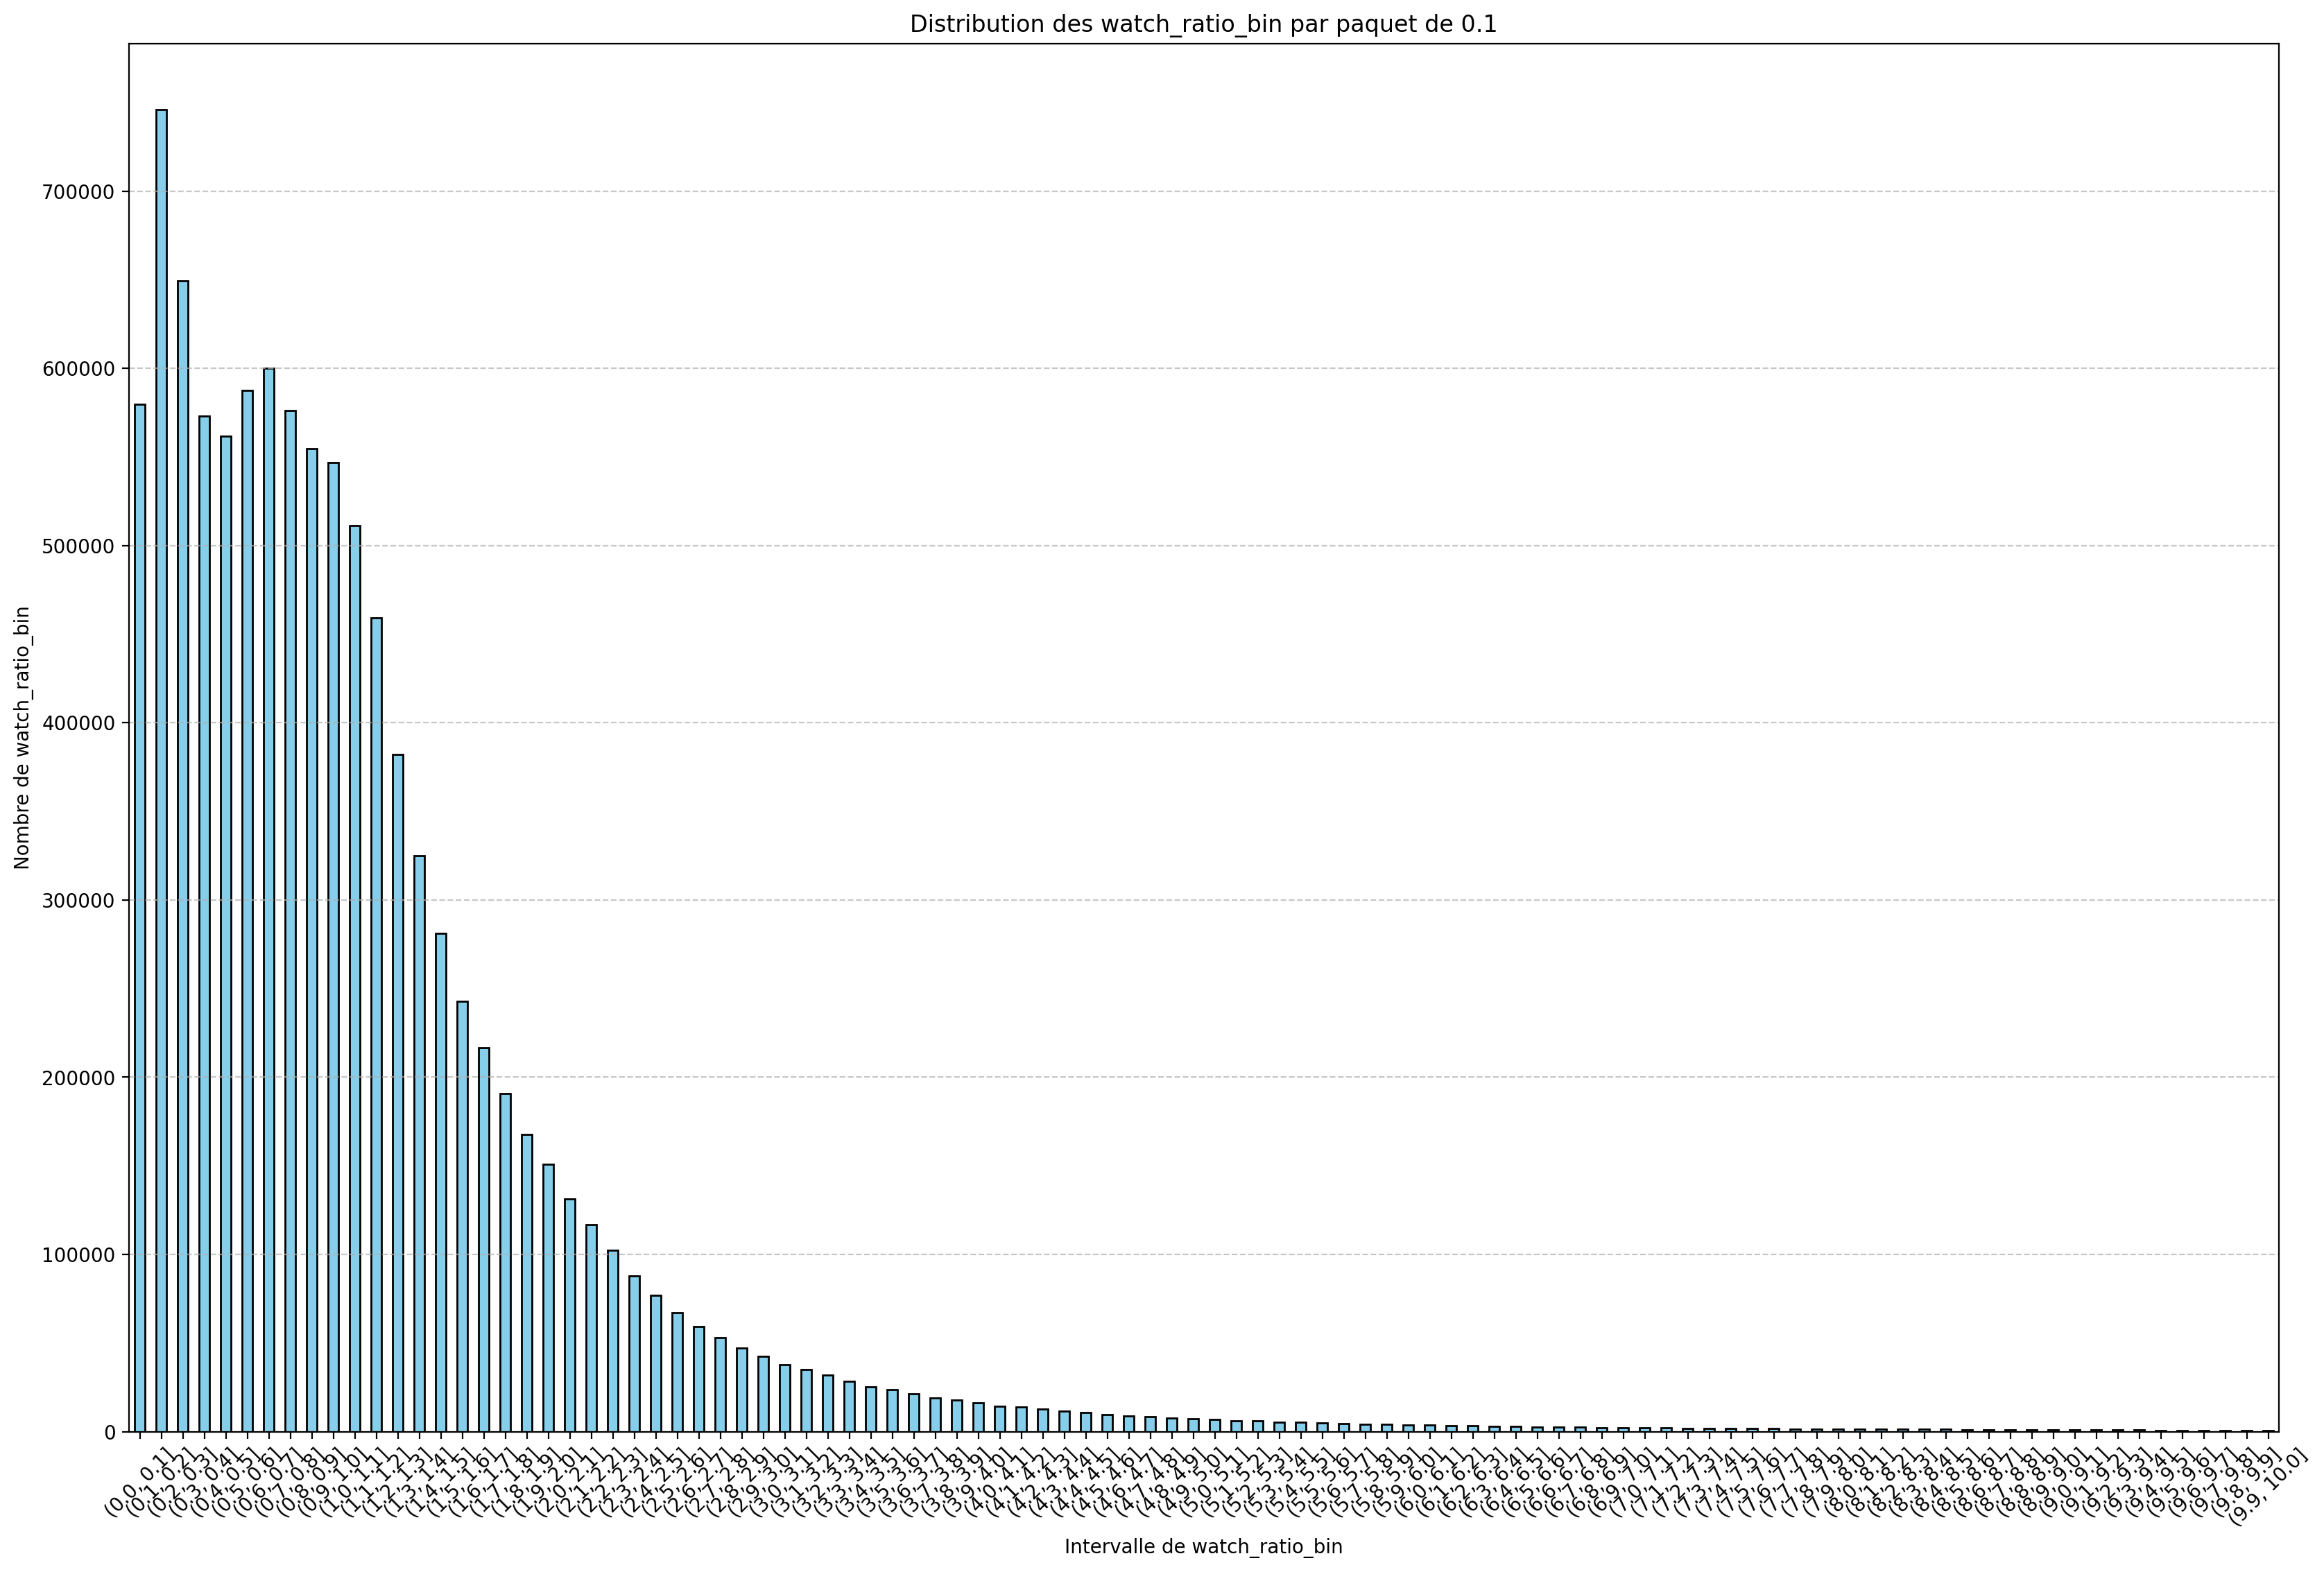

In [16]:

interactions_train_filtered['watch_ratio_bin'] = pd.cut(interactions_train_filtered['watch_ratio'], bins=np.arange(0, 10.1, 0.1))
print(f"Max watch_ratio: {interactions_train_filtered['watch_ratio'].max()}")
print(f"Min watch_ratio: {interactions_train_filtered['watch_ratio'].min()}")

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_train_filtered['watch_ratio_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio_bin par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio_bin")
plt.ylabel("Nombre de watch_ratio_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Max watch_ratio: 571.5214280603849
Min watch_ratio: 0.0


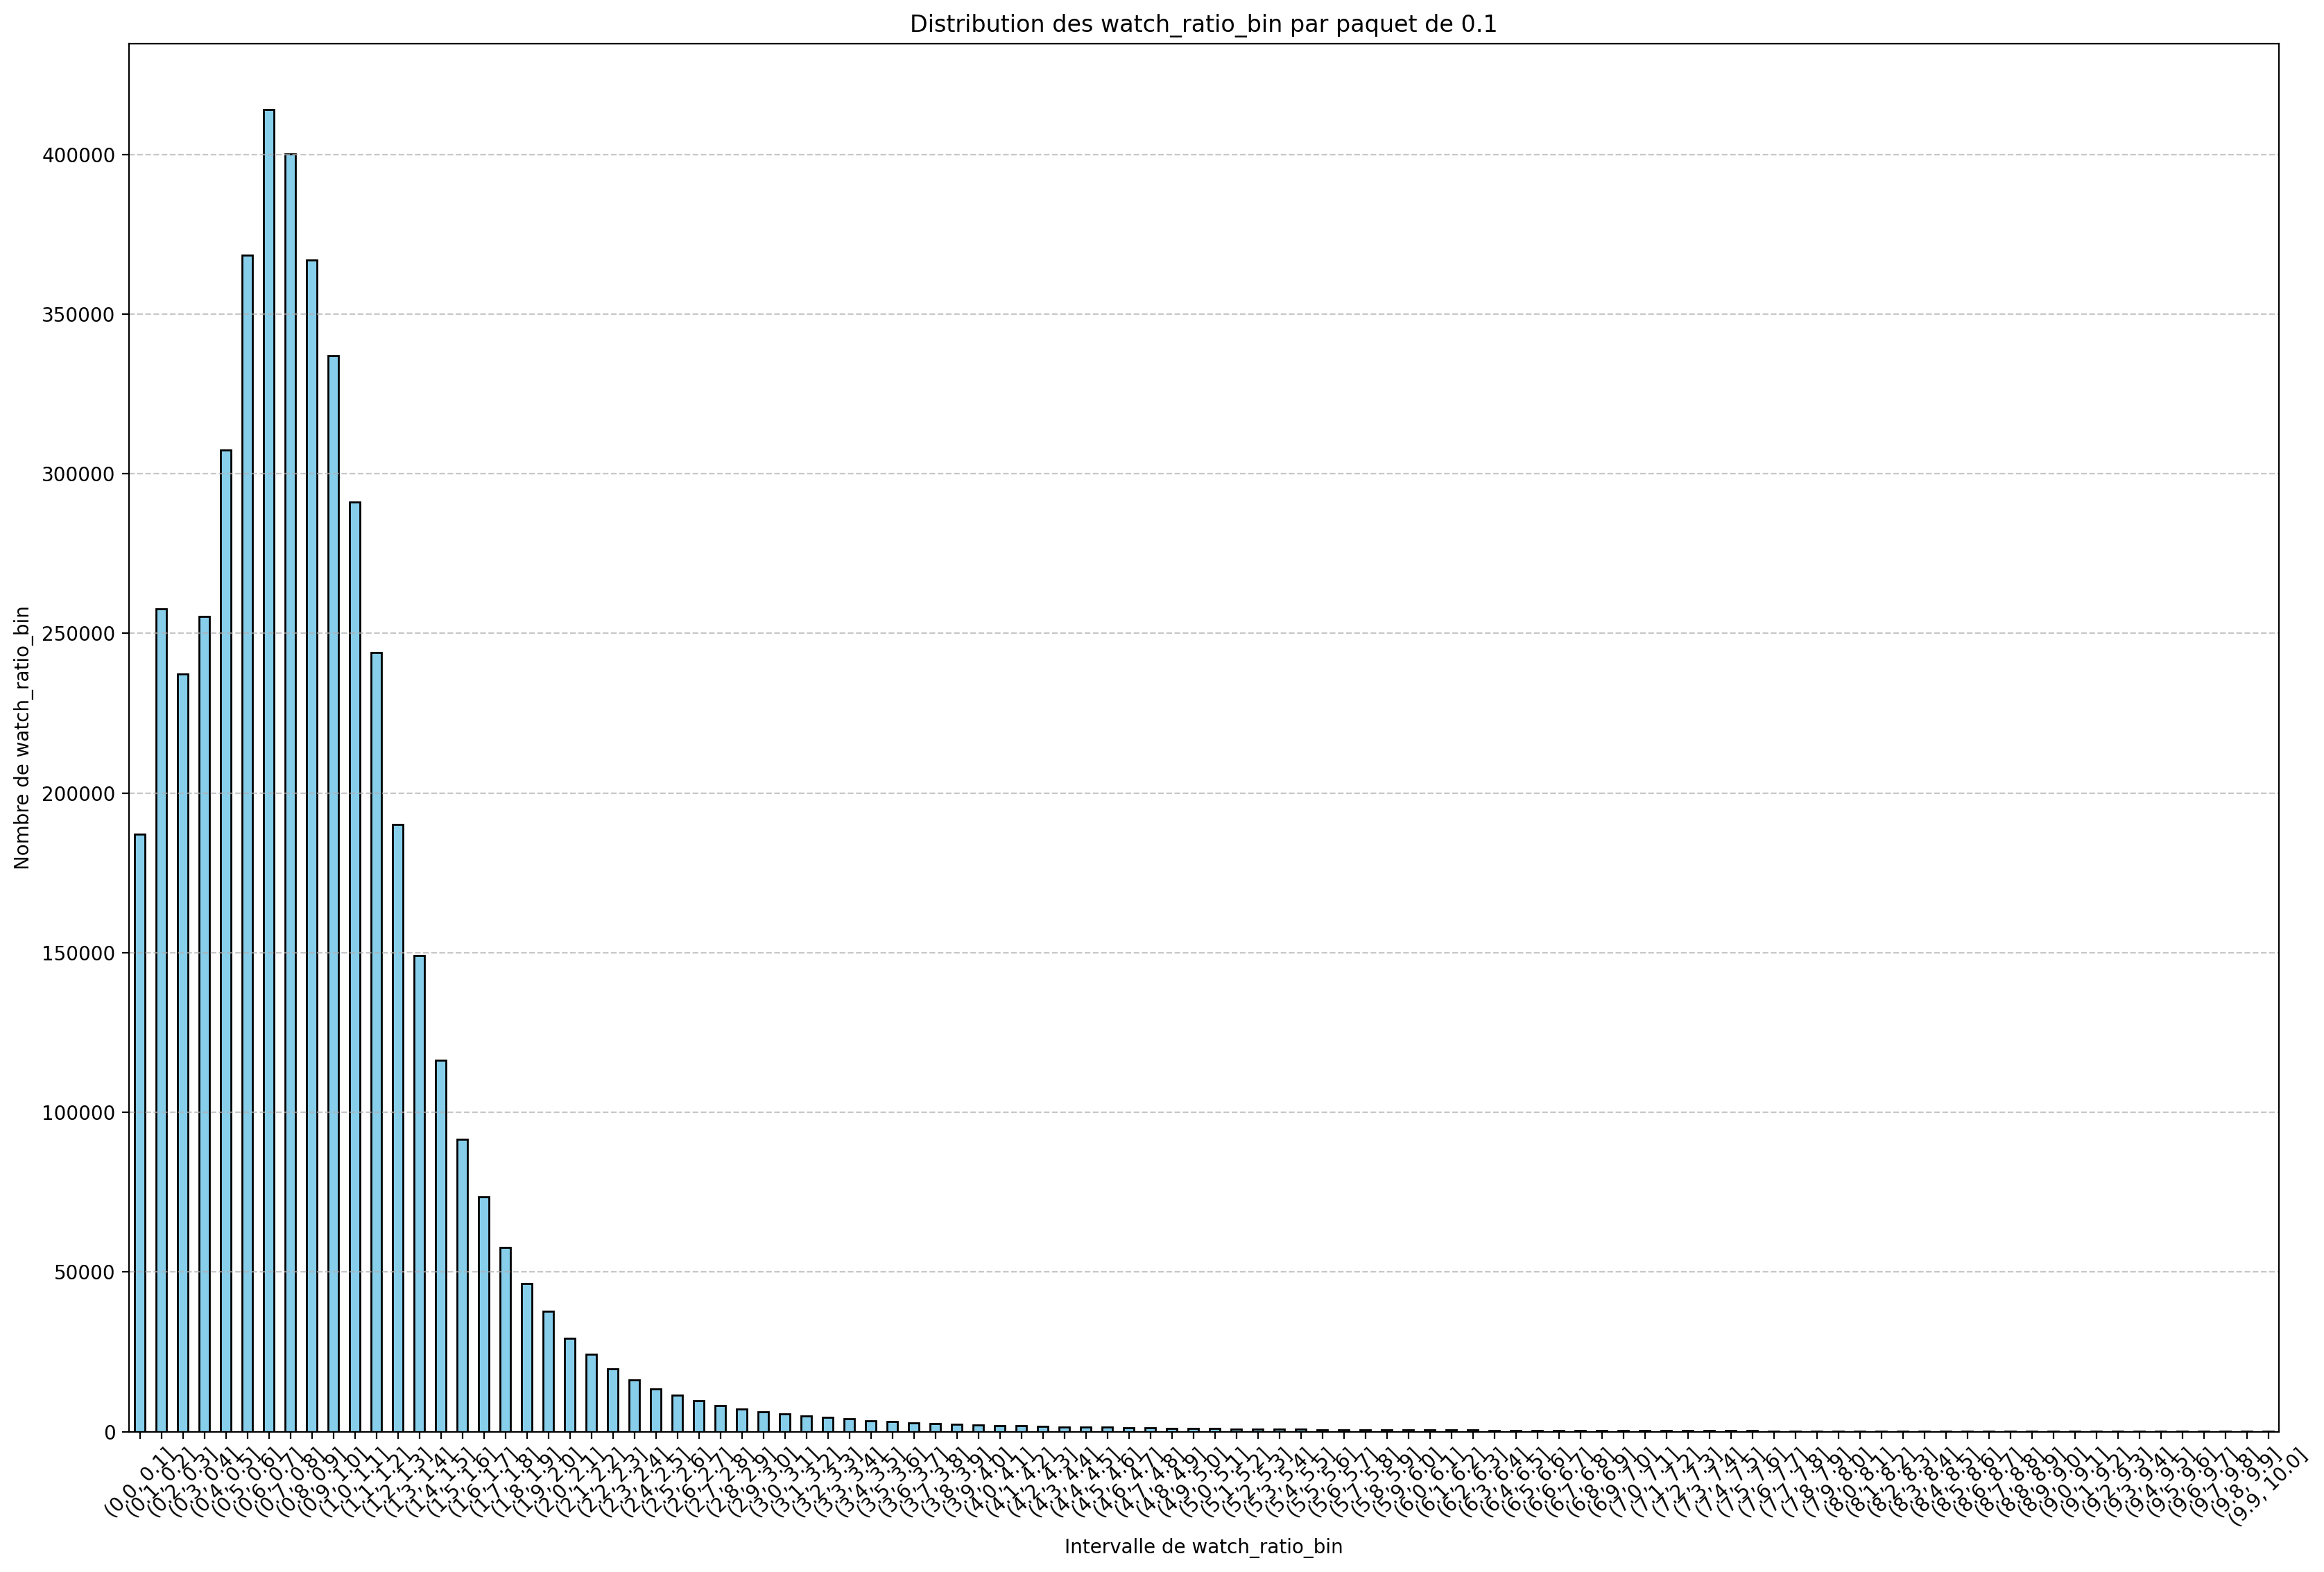

In [17]:

interactions_test_filtered['watch_ratio_bin'] = pd.cut(interactions_test_filtered['watch_ratio'], bins=np.arange(0, 10.1, 0.1))
print(f"Max watch_ratio: {interactions_test_filtered['watch_ratio'].max()}")
print(f"Min watch_ratio: {interactions_test_filtered['watch_ratio'].min()}")

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_test_filtered['watch_ratio_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio_bin par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio_bin")
plt.ylabel("Nombre de watch_ratio_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Comme je travaille des videos en format court, il faut reussir a capter l'attention je considere que l'user aime une video si le watch_ratio est superieur a 2.0, ce seuil est peut etre haut car on peut aime une video et la regarder qu'une fois mais je veux essayer de recommander les videos plus pertinente


In [21]:
interactions_train_filtered['relevant'] = np.where(interactions_train_filtered['watch_ratio'] >= 2.0, 1, 0)
interactions_test_filtered['relevant'] = np.where(interactions_test_filtered['watch_ratio'] >= 2.0, 1, 0)

Je souhaite l'als, puisque ce n'est pas vraiment des rating, je vais utiliser les parametres implicites, je dois donc utiliser des poids de confiance, pour rajouter un lissage je veux considirer le poids 0.5 les interactions avec un watch ratio entre 1 et 2


In [28]:
def soft_binarize_watch_ratio(watch_ratio):
    if watch_ratio < 1:
        return 0.0
    elif watch_ratio < 2:
        return 0.5
    else:
        return 1.0

interactions_train_filtered['weight'] = interactions_train_filtered['watch_ratio'].apply(soft_binarize_watch_ratio)
interactions_test_filtered['weight'] = interactions_test_filtered['watch_ratio'].apply(soft_binarize_watch_ratio)



TODO: moyenne par user ?


In [22]:
# Statistiques sur le rating dans le train
print("=== Statistiques sur le relevant (train) ===")
print(interactions_train_filtered['relevant'].value_counts())
print(interactions_train_filtered['relevant'].value_counts(normalize=True))


# Statistiques sur le rating dans le test
print("\n=== Statistiques sur le relevant (test) ===")
print(interactions_test_filtered['relevant'].value_counts())
print(interactions_test_filtered['relevant'].value_counts(normalize=True))




=== Statistiques sur le relevant (train) ===
relevant
0    8996303
1    1304666
Name: count, dtype: int64
relevant
0    0.873345
1    0.126655
Name: proportion, dtype: float64

=== Statistiques sur le relevant (test) ===
relevant
0    4459341
1     217229
Name: count, dtype: int64
relevant
0    0.95355
1    0.04645
Name: proportion, dtype: float64


In [29]:
interactions_train_filtered.to_csv("interactions_train.csv", index=False)
interactions_test_filtered.to_csv("interactions_test.csv", index=False)


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import matplotlib.pyplot as plt
import logging


In [25]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").config("spark.driver.memory", "12g") .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 12:15:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
interactions_train_spark = spark.read.option("header", "true").csv("./interactions_train.csv")

interactions_train_spark.show(100, truncate=True)




+-------+--------+-------------------+---------------+------+--------+
|user_id|video_id|        watch_ratio|watch_ratio_bin|weight|relevant|
+-------+--------+-------------------+---------------+------+--------+
|      0|      42|  1.098951081407222|     (1.0, 1.1]|   0.5|       0|
|      0|      67|   2.75963546610974|     (2.7, 2.8]|   1.0|       1|
|      0|      80| 1.1880172413793104|     (1.1, 1.2]|   0.5|       0|
|      0|     110| 1.4086274509803922|     (1.4, 1.5]|   0.5|       0|
|      0|     128|  1.281866973356335|     (1.2, 1.3]|   0.5|       0|
|      0|     130| 0.0795647399420984|     (0.0, 0.1]|   0.0|       0|
|      0|     133| 2.4584473324213407|     (2.4, 2.5]|   1.0|       1|
|      0|     139| 0.0725128205128205|     (0.0, 0.1]|   0.0|       0|
|      0|     147| 0.0765768884580765|     (0.0, 0.1]|   0.0|       0|
|      0|     151|  1.614911509978662|     (1.6, 1.7]|   0.5|       0|
|      0|     152| 2.3260869565217392|     (2.3, 2.4]|   1.0|       1|
|     

In [31]:
interactions_test_spark = spark.read.option("header", "true").csv("./interactions_test.csv")
interactions_test_spark.show(100, truncate=True)

+-------+--------+------------------+---------------+--------+------+
|user_id|video_id|       watch_ratio|watch_ratio_bin|relevant|weight|
+-------+--------+------------------+---------------+--------+------+
|     14|     103| 0.429126213592233|     (0.4, 0.5]|       0|   0.0|
|     14|     109| 1.482039397450753|     (1.4, 1.5]|       0|   0.5|
|     14|     120|0.7287378330939843|     (0.7, 0.8]|       0|   0.0|
|     14|     122|0.4778097390589685|     (0.4, 0.5]|       0|   0.0|
|     14|     128|0.4393329499712478|     (0.4, 0.5]|       0|   0.0|
|     14|     130|1.1502445842068485|     (1.1, 1.2]|       0|   0.5|
|     14|     131|1.8163166004379208|     (1.8, 1.9]|       0|   0.5|
|     14|     133|0.7811217510259918|     (0.7, 0.8]|       0|   0.0|
|     14|     136|1.5543964232488825|     (1.5, 1.6]|       0|   0.5|
|     14|     137|2.3074857043839887|     (2.3, 2.4]|       1|   1.0|
|     14|     139|0.4628717948717948|     (0.4, 0.5]|       0|   0.0|
|     14|     142|1.

In [32]:
from pyspark.sql.functions import col, when

In [ ]:
indexer = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['user_id', 'video_id']
]

pipeline = Pipeline(stages=indexer)

# 2. Entraîner le pipeline
pipeline_model = pipeline.fit(interactions_train_spark)

# 3. Transformer les données d'entraînement
interactions_train_spark_transformed = pipeline_model.transform(interactions_train_spark)

# 4. Forcer rating en float
interactions_train_spark_transformed = interactions_train_spark_transformed.withColumn("relevant", col("relevant").cast("float"))


# 5. Entraîner le modèle ALS

# ------------------------
# Données de test : small_matrix
# ------------------------

# 6. Charger small_matrix.csv


# 10. Transformer avec le pipeline entraîné
interactions_test_spark_transformed = pipeline_model.transform(interactions_test_spark)

# 11. Forcer rating en float
interactions_test_spark_transformed = interactions_test_spark_transformed.withColumn("relevant", col("relevant").cast("float"))





In [43]:
interactions_train_spark_transformed = interactions_train_spark_transformed.withColumn("relevant", col("relevant").cast("float"))
interactions_test_spark_transformed = interactions_test_spark_transformed.withColumn("relevant", col("relevant").cast("float"))


In [44]:
als = ALS(
    maxIter=5,
    regParam=0.09,
    rank=100,
    userCol="user_id_index",
    itemCol="video_id_index",
    ratingCol="relevant",
    implicitPrefs=True,
    alpha=10.0,
    coldStartStrategy="drop",
    nonnegative=True,
)
model = als.fit(interactions_train_spark_transformed)




# 12. Prédictions
predictions = model.transform(interactions_test_spark_transformed)

# 13. Affichage
predictions.show()

+-------+--------+------------------+---------------+--------+------+-------------+--------------+------------+
|user_id|video_id|       watch_ratio|watch_ratio_bin|relevant|weight|user_id_index|video_id_index|  prediction|
+-------+--------+------------------+---------------+--------+------+-------------+--------------+------------+
|    815|     389|0.4216375914462577|     (0.4, 0.5]|     0.0|   0.0|       6773.0|        1645.0|  0.07711998|
|    815|    2502|12.695567010309276|           NULL|     1.0|   1.0|       6773.0|        2866.0|  0.15755992|
|    815|    3809|0.3554761904761905|     (0.3, 0.4]|     0.0|   0.0|       6773.0|         496.0|  0.04588753|
|    815|    4220| 1.576001071380742|     (1.5, 1.6]|     0.0|   0.5|       6773.0|        1959.0| 0.020783028|
|    815|    4270|1.4163855421686746|     (1.4, 1.5]|     0.0|   0.5|       6773.0|         471.0| 0.055988133|
|    815|    6094|0.1250155285933165|     (0.1, 0.2]|     0.0|   0.0|       6773.0|        3997.0|0.0023

In [45]:
predictions_pandas = predictions.toPandas()
predictions_pandas.head(10)


,user_id,video_id,watch_ratio,watch_ratio_bin,relevant,weight,user_id_index,video_id_index,prediction
0,815,103,1.6032038834951456,"(1.6, 1.7]",0.0,0.5,6773.0,2724.0,0.022483
1,815,109,1.519634350457062,"(1.5, 1.6]",0.0,0.5,6773.0,3147.0,0.002535
2,815,120,2.0564863571086645,"(2.0, 2.1]",1.0,1.0,6773.0,3285.0,0.039087
3,815,122,1.213375796178344,"(1.2, 1.3]",0.0,0.5,6773.0,3135.0,0.102362
4,815,128,1.6025493578685068,"(1.6, 1.7]",0.0,0.5,6773.0,3431.0,0.002340
5,815,130,3.1003294399520813,"(3.1, 3.2]",1.0,1.0,6773.0,2854.0,0.000020
6,815,131,1.7217581704646825,"(1.7, 1.8]",0.0,0.5,6773.0,3652.0,0.003531
7,815,133,1.7517099863201095,"(1.7, 1.8]",0.0,0.5,6773.0,3521.0,0.013321
8,815,136,0.4022490177482726,"(0.4, 0.5]",0.0,0.0,6773.0,3586.0,0.103927
9,815,139,0.3078974358974359,"(0.3, 0.4]",0.0,0.0,6773.0,1047.0,0.106537


In [47]:
def evaluate_implicit_at_k(df, k):
    """
    df doit contenir :
    - user_id
    - item_id
    - prediction (score implicite ALS)
    - rating (1 si watch_ratio > 2.0, 0 sinon)

    Retourne : dict avec precision, recall, ndcg, map
    """

    # On utilise directement la colonne binaire rating comme signal de pertinence


    # Trier par utilisateur et score prédiction décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Rang des prédictions
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Top-K par utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()

    # Precision@k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Recall@k
    total_relevant_per_user = df.groupby('user_id')['relevant'].sum()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user
    recall_per_user = recall_per_user.fillna(0)

    # DCG@k
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # IDCG@k (ordre idéal : on prend les k premiers relevant=1 pour chaque user)
    ideal = df[df['relevant'] == 1].copy()
    ideal['rank'] = ideal.groupby('user_id')['prediction'].rank(method='first', ascending=False)

    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    ndcg = (dcg / idcg).fillna(0)

    # MAP@k
    def average_precision(group):
        # group est un sous-DataFrame pour un user (sans la colonne user_id ici)
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    # Utiliser la version clean sans warning
    map_per_user = top_k.groupby('user_id', group_keys=False).apply(
    average_precision, include_groups=False
)




    # Retour global
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }

In [48]:
# Ensure 'relevant' is integer type
predictions_pandas['relevant'] = predictions_pandas['relevant'].astype(int)
evaluate_implicit_at_k(predictions_pandas, 10)

{'precision': np.float64(0.15974486180014177),
 'recall': np.float64(0.02740785602683555),
 'ndcg': np.float64(0.15990392886282936),
 'map': np.float64(0.2695143036018513)}

In [ ]:
# Ensure 'relevant' is integer type
predictions_pandas['relevant'] = predictions_pandas['relevant'].astype(int)
evaluate_implicit_at_k(predictions_pandas, 10)

{'precision': np.float64(0.04961020552799433),
 'recall': np.float64(0.004648289740352167),
 'ndcg': np.float64(0.053590814158479314),
 'map': np.float64(0.13096334919509972)}

In [47]:
evaluate_implicit_at_k(predictions_pandas, 10)


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


{'precision': np.float32(0.087526575),
 'recall': np.float32(0.008789529),
 'ndcg': np.float64(0.10681996082371704),
 'map': np.float64(0.2820857774643168)}

In [52]:
evaluate_implicit_at_k(predictions_pandas, 10)


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


{'precision': np.float32(0.18199858),
 'recall': np.float32(0.031102646),
 'ndcg': np.float64(0.19178363590536077),
 'map': np.float64(0.3261786025838595)}

Calculating metrics for k=1...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=2...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=3...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=4...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=5...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=6...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=7...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=8...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=9...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=10...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=11...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=12...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=13...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=14...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=15...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=16...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=17...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=18...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=19...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=20...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=21...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=22...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=23...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=24...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=25...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=26...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=27...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=28...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=29...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=30...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=31...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=32...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=33...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=34...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=35...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=36...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=37...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=38...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=39...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=40...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=41...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=42...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=43...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=44...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=45...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=46...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=47...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=48...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=49...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


Calculating metrics for k=50...


/var/folders/yx/8cyn8k8d22v0l12gqb0cfk100000gn/T/ipykernel_11634/4072758406.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_per_user = top_k.groupby('user_id').apply(average_precision)


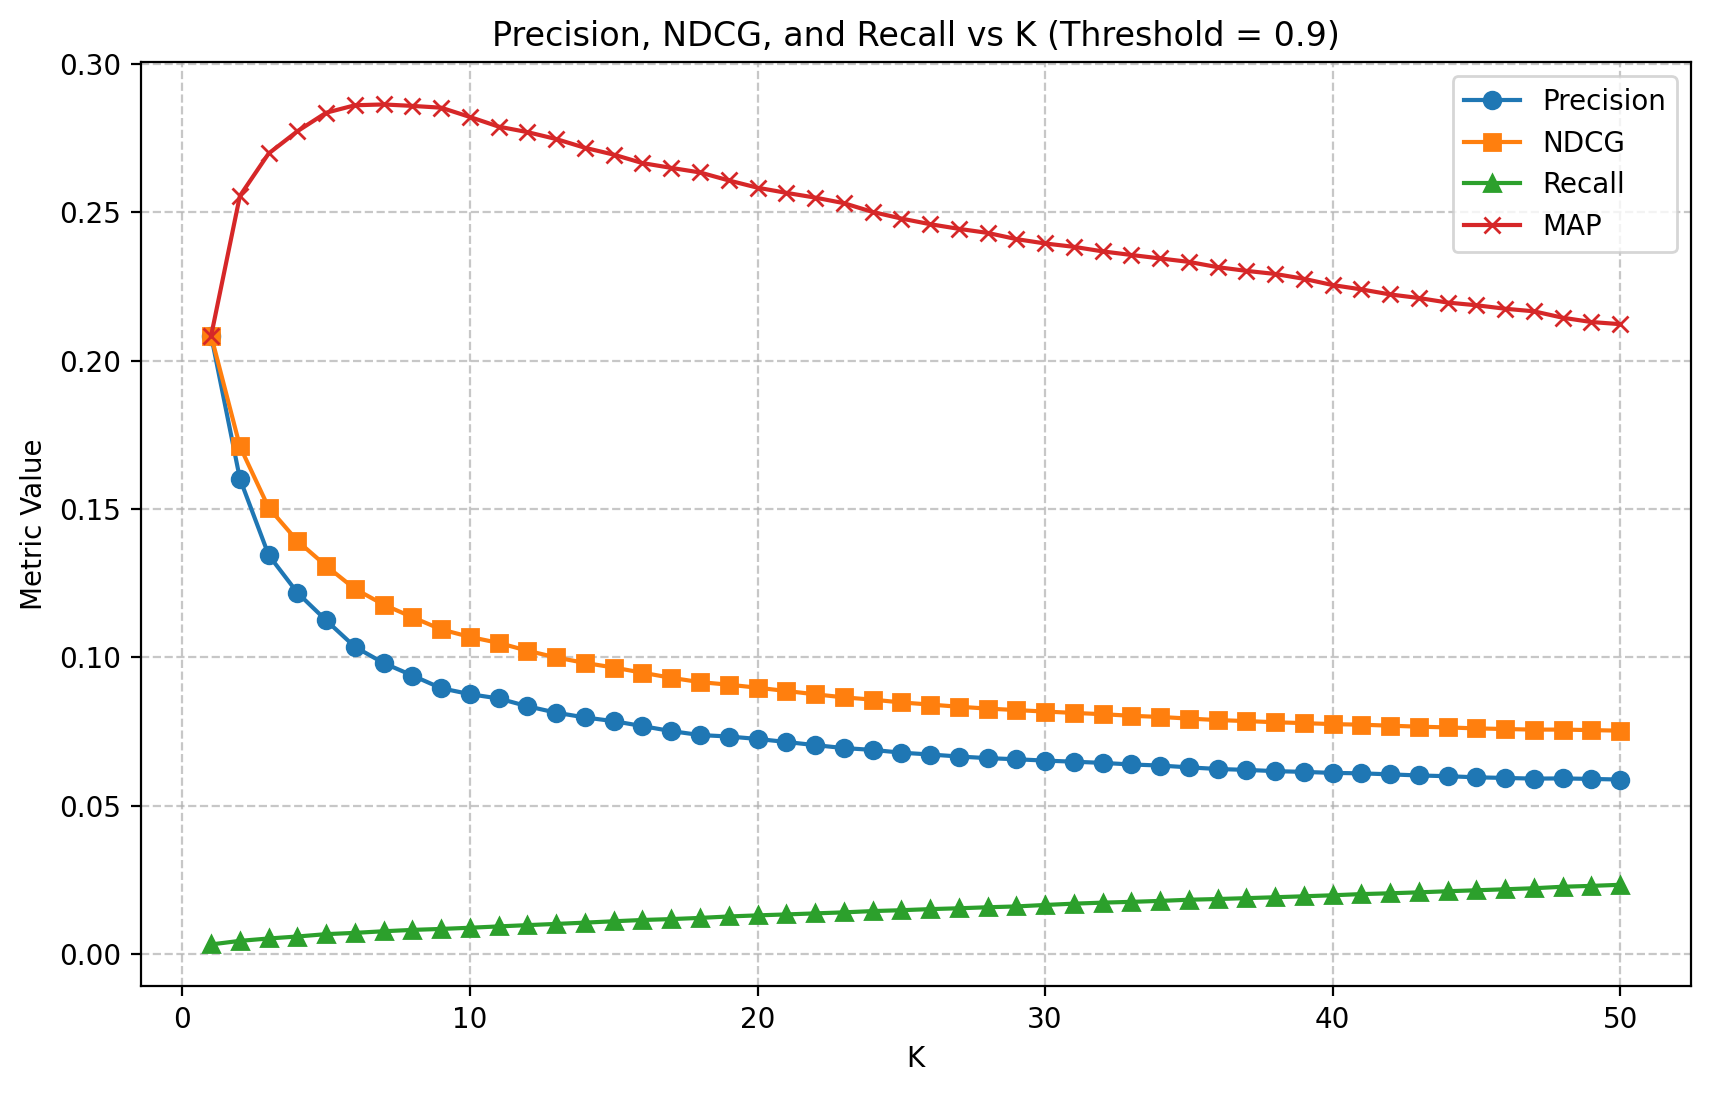

In [48]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_implicit_at_k(predictions_pandas, k)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

Calculating metrics for k=1...
Calculating metrics for k=2...
Calculating metrics for k=3...
Calculating metrics for k=4...
Calculating metrics for k=5...
Calculating metrics for k=6...
Calculating metrics for k=7...
Calculating metrics for k=8...
Calculating metrics for k=9...
Calculating metrics for k=10...
Calculating metrics for k=11...
Calculating metrics for k=12...
Calculating metrics for k=13...
Calculating metrics for k=14...
Calculating metrics for k=15...
Calculating metrics for k=16...
Calculating metrics for k=17...
Calculating metrics for k=18...
Calculating metrics for k=19...
Calculating metrics for k=20...
Calculating metrics for k=21...
Calculating metrics for k=22...
Calculating metrics for k=23...
Calculating metrics for k=24...
Calculating metrics for k=25...
Calculating metrics for k=26...
Calculating metrics for k=27...
Calculating metrics for k=28...
Calculating metrics for k=29...
Calculating metrics for k=30...
Calculating metrics for k=31...
Calculating metri

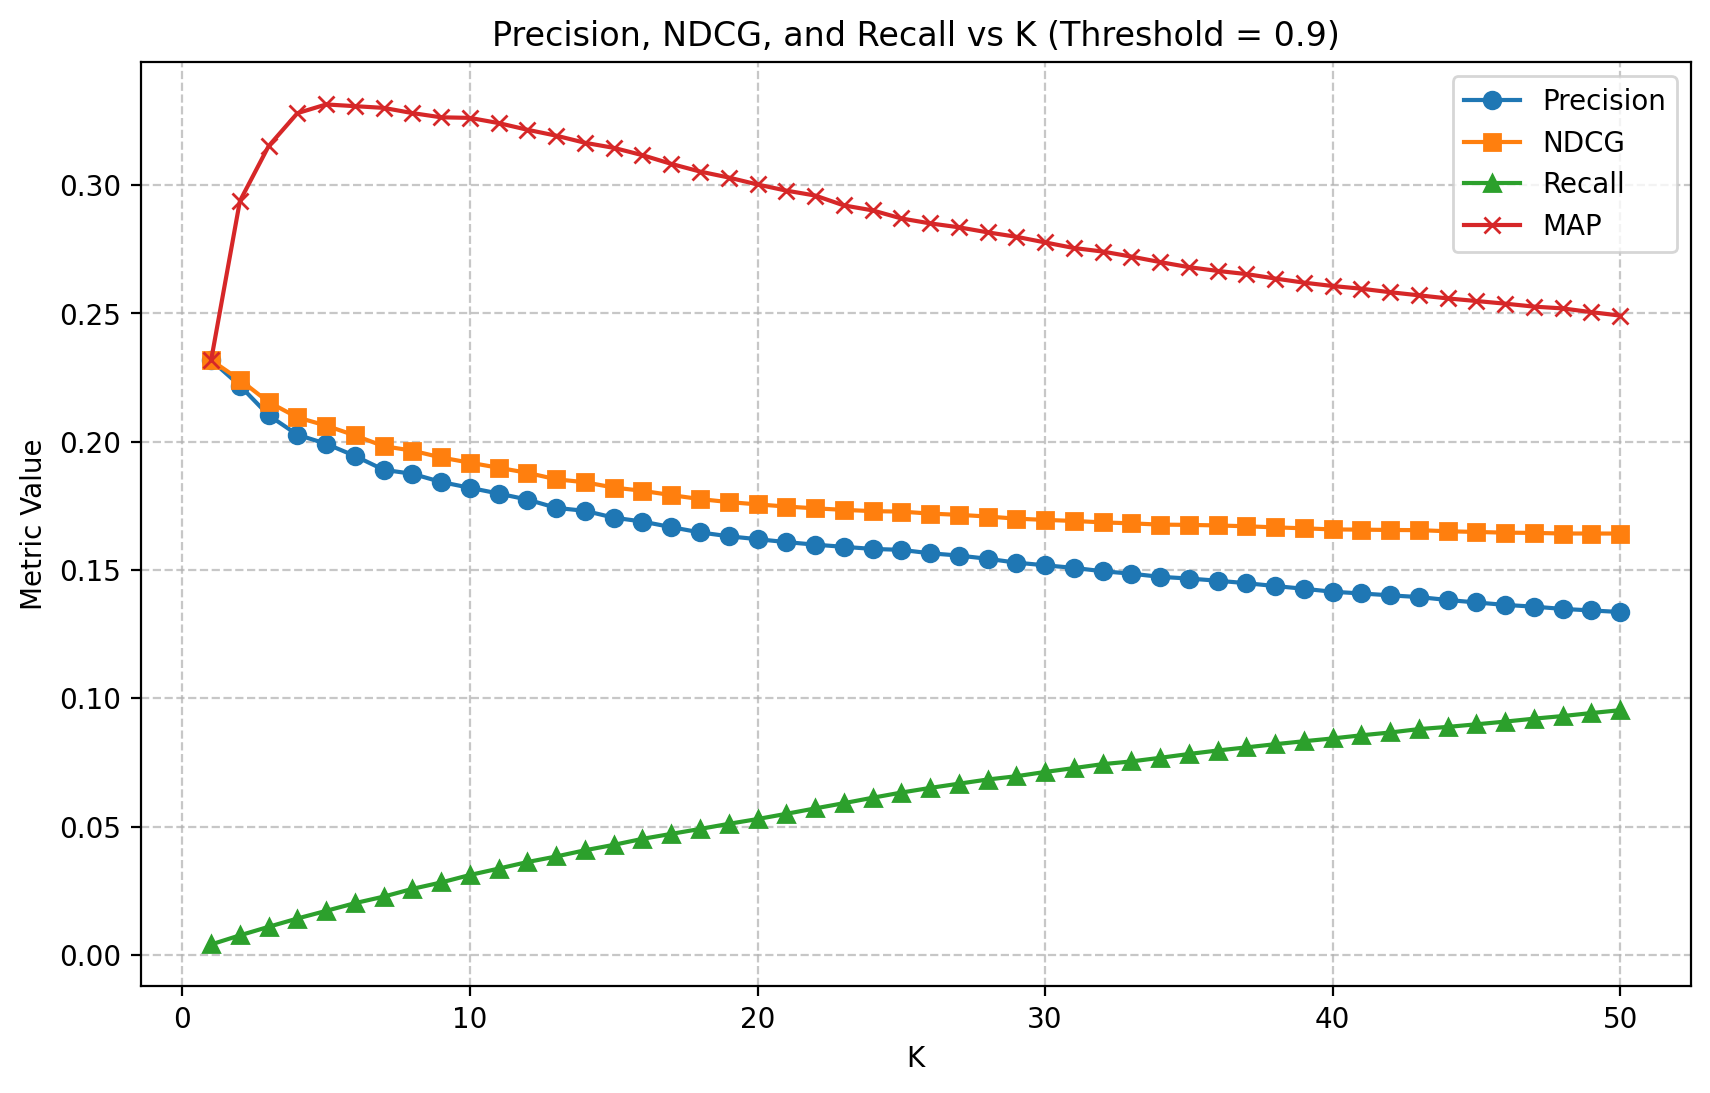

In [62]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_implicit_at_k(predictions_pandas, k)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()